# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to walk a user through [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus).**


<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. allow the user to create a Level-of-Detail 1 (LoD1) [3D City Model](https://en.wikipedia.org/wiki/3D_city_model).**  *---It saves the `overpass`.geojson to prevent calling OSM after every failure. Peruse `matplotlib` figure at you leisure.* 
>
> **2. propose several [Geography and Sustainable Development Education *conversation starters*](#Section2) for Secondary and Tertiary level students**
</div>

In [1]:
import time
from datetime import timedelta

import os
from itertools import chain#, izip

import requests
import overpass
import osm2geojson

import pyrosm

import numpy as np
import pandas as pd
import geopandas as gpd
import topojson as tp

import shapely
import shapely.geometry as sg
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, LinearRing, shape, mapping
from shapely.ops import snap
from shapely.ops import transform

import fiona
import copy
import json
import geojson

import pyproj

import city3D

from osgeo import gdal, ogr, osr

import triangle as tr

from openlocationcode import openlocationcode as olc

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

**A `parameter.json` defines the path and files**.

In [3]:
jparams = json.load(open('osm3DwStock_param.json'))       
#jparams = json.load(open('osm3DsRiver_param.json'))      
#jparams = json.load(open('osm3Dobs_param.json'))          

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - interogate an osm.pbf (["Protocolbuffer Binary Format"](https://wiki.openstreetmap.org/wiki/PBF_Format)) with [pyrosm]() from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b></b> 
    
**We can start with data via the `pyrosm` auto-download.** 
</div>

In [4]:
# update=False to use an existing osm.pbf [to much data]
#fp = pyrosm.get_data("South Africa", update=False, directory="data")

#- city-level [not updated as often as below]
fp = pyrosm.get_data("Cape Town", update=True, directory="data")  

Downloaded Protobuf data 'CapeTown.osm.pbf' (18.99 MB) to:
'/Users/adriankriger/Documents/osm_LoD1_3DCityModel/districts/data/CapeTown.osm.pbf'


<div class="alert alert-block alert-info"><b></b> 
    
**...or download your own. Provincial extracts for South Africa are available here:** *http://download.openstreetmap.fr/extracts/africa/south_africa/*</div>

In [5]:
#- recommended. updated often. 
#fp = './data/western_cape-latest.osm.pbf'  

In [6]:
#aoi.plot()

In [7]:
start = time.time()

# get the shapely geometry from the aoi.GeoDataFrame
#bbox_geom = aoi['geometry'].values[0]
# initiliaze (with bounding box)
osm = pyrosm.OSM(fp)#, bounding_box=bbox_geom)
# retrieve buildings
ts = osm.get_buildings(extra_attributes=['addr:suburb', 'building:part', 'rooms', 'beds', 'residential', 'building:min_level', 'min_height', 'building:units', 'social_facility'])

print(len(ts), ' buildings')
end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

211020  buildings
runtime: 0:00:13.237894


In [8]:
#- get the area [suburb] 
query = """[out:json][timeout:30];
            area[boundary=administrative][name='{0}'];
            wr[place~"^(sub|town|city|count|state)"][name='{1}'](area);
            out geom;
        """.format(jparams['LargeArea'], jparams['FocusArea'])

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
area = osm2geojson.json2geojson(r.json())
#read into .gpd
aoi = gpd.GeoDataFrame.from_features(area['features'])
aoi = aoi.set_crs(4326, allow_override=True)

In [9]:
#- trim rows. the reason this is here and not part of the pyrosm process [above] is; pyrosm breaks some features

ar = ts.within(aoi['geometry'].values[0])
#creating a new geoDataFrame that will have only the intersecting records
ts = ts.loc[ar].copy()
#resetting index(optional step if you don't need to keep the original index values)
ts.reset_index(inplace=True, drop=True)

In [10]:
#ts.plot()
#ts['tags'].unique()

In [11]:
# basic cleaning to harvest building=* (no building:part=*) and building=levels tags only

ts.dropna(subset=['building:levels'], inplace= True)
ts['building:levels'] = pd.to_numeric(ts['building:levels'], downcast='integer')
ts['building:levels'] = ts['building:levels'].astype(int)
#- we only want buildings with =levels data
ts = ts[ts['building:levels'] != 0]
ts['building:levels'] = ts['building:levels'].replace('None', np.nan)#, inplace=True)
ts = ts[ts['building:levels'].notna()]

#- without building:part
ts = ts[ts['building:part'].isnull()]

In [12]:
# have a look
ts.head(2)

,addr:city,addr:country,addr:full,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,opening_hours,operator,phone,ref,visible,website,building,amenity,building:flats,building:levels,building:material,building:min_level,building:use,craft,height,internet_access,landuse,office,shop,source,start_date,wikipedia,addr:suburb,building:part,rooms,beds,residential,min_height,building:units,social_facility,id,timestamp,version,tags,osm_type,geometry,changeset
0,Cape Town,None,None,None,None,None,None,None,None,Woodstock Station,None,None,None,None,False,None,train_station,None,None,3,None,None,None,None,None,None,None,None,ticket,None,None,None,Woodstock,None,None,None,None,None,None,None,65768975,0,0,"{""public_transport"":""station"",""railway"":""stati...",way,"POLYGON ((18.44598 -33.92561, 18.44606 -33.925...",NaN
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,None,industrial,None,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,239784858,0,0,"{""layer"":""1""}",way,"POLYGON ((18.44740 -33.92310, 18.44806 -33.923...",NaN


In [13]:
#- coordinate reference system
ts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>
<br>
<br>

We need the ***Projected*** Coordinate Reference System.  

In [14]:
#- estimate utm: internal geopandas function
ts.estimate_utm_crs()

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `espg` in the _`cell`_ below** </div>

In [15]:
#- fill <Projected CRS: EPSG:32734> from above here epsg = EPSG:32734
epsg = 'EPSG:32734'

In [16]:
#project blds
ts = ts.to_crs(epsg)
#project aoi
aoi = aoi.to_crs(epsg)

**Now we process.**  

In [17]:
aoibuffer = aoi.copy()

def buffer01(row):
    with np.errstate(invalid='ignore'):
        return row.geometry.buffer(150, cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)
    
extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]

**Now the DEM**  
*one is available at [raster](https://github.com/AdrianKriger/geo3D/suburb/tree/main/raster)*

In [18]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")
gdal.UseExceptions() 

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    dstSRS=epsg,
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [19]:
# raster to xyz
xyz = gdal.Translate(jparams['xyz'], 
                     jparams['projClip_raster'],
                     format = 'XYZ')#, 
                     #noData = float(0))
xyz = None

**prepare to harvest elevation**

In [20]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [21]:
#- harvest buildings
ts.drop(ts.index[ts['osm_type'] == 'node'], inplace = True)

#- orient segments and simplify topology
topo = tp.Topology(ts, prequantize=False, winding_order='CCW_CW')
with np.errstate(invalid='ignore'):
    ts = topo.toposimplify(0.25).to_gdf()

In [22]:
# prepare to plot (more buildings = more time) 
start = time.time()

ts_copy = ts.copy()
new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
ts_copy.drop(ts_copy.index[ts_copy['building'] == 'bridge'], inplace = True)
ts_copy.drop(ts_copy.index[ts_copy['building'] == 'roof'], inplace = True)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:01:43.690930


**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

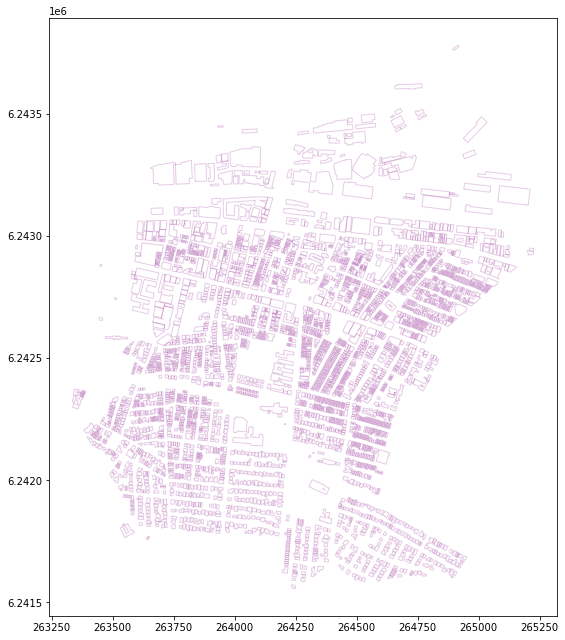

In [23]:
#%matplotlib

fig, ax = plt.subplots(figsize=(11, 11))

ts.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|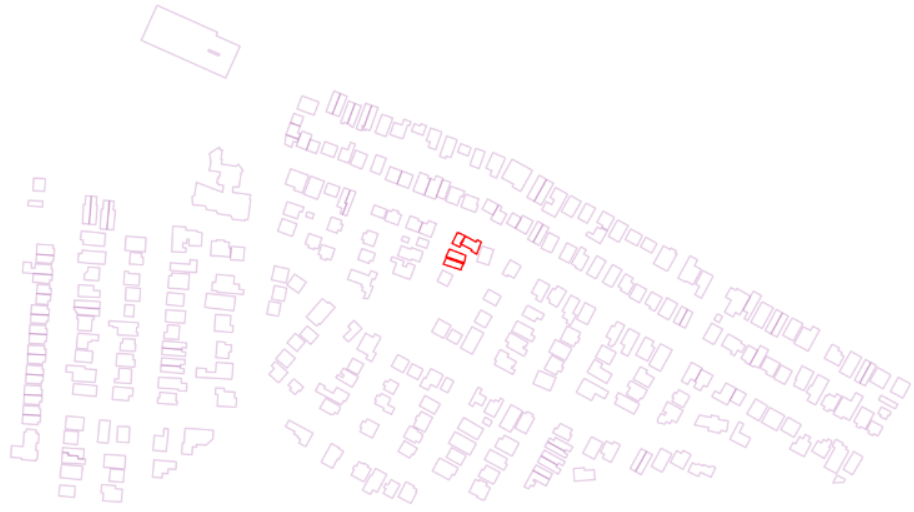 | **Challenges will be highlight in *Red*.**|
|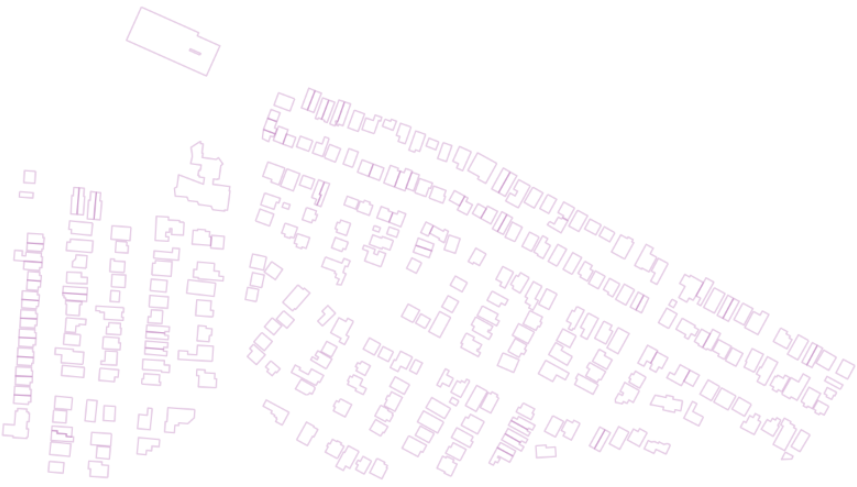| **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-warning"><b></b>
    
And remember.  
Many [Planet.osm mirrors](https://wiki.openstreetmap.org/wiki/Planet.osm) (like the one recommended above) release a ***fresh `.osm.pbf` EVERYDAY!***  
Give the OpenStreetMap server ***at least a day*** before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

In [24]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)

,geometry,addr:city,addr:country,addr:full,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,opening_hours,operator,phone,ref,visible,website,building,amenity,building:flats,building:levels,building:material,building:min_level,building:use,craft,height,internet_access,landuse,office,shop,source,start_date,wikipedia,addr:suburb,building:part,rooms,beds,residential,min_height,building:units,social_facility,id,timestamp,version,tags,osm_type,changeset,mean
0,"POLYGON ((263906.869 6243153.811, 263907.735 6...",Cape Town,None,NaN,None,None,None,None,None,None,Woodstock Station,None,None,None,None,False,None,train_station,None,None,3,NaN,None,None,None,None,None,None,None,ticket,None,None,None,Woodstock,NaN,None,None,None,NaN,None,None,65768975,0,0,"{""public_transport"":""station"",""railway"":""stati...",way,NaN,4.63
1,"POLYGON ((264031.485 6243436.344, 264032.019 6...",None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,False,None,industrial,None,None,1,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,None,239784858,0,0,"{""layer"":""1""}",way,NaN,2.46


<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute `height`.</div>

The Python code to execute the `.writejson` function is in the `city3D.py` script

In [25]:
# -- execute function. write geoJSON
city3D.writegjsonD(ts, jparams, epsg)

In [26]:
from shapely.geometry import polygon
import math

start = time.time()

dis = gpd.read_file(jparams['osm_bldings'])                   
dis.set_crs(epsg=int(epsg[-5:]), inplace=True, allow_override=True)

dict_vertices = {}
cols = [c for c in ['bottom_bridge_height', 'bottom_roof_height', 'roof_height'] if c in dis.columns]

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

for i, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    name = row['osm_id']
    for (j, v) in enumerate(oring[:-1]):
        vertex = (oring[j][0], oring[j][1])
        attr = [row[c] for c in cols]
        attr = [x for x in attr if not np.isnan(x)]  # Remove np.nan values
        if vertex in dict_vertices.keys():
            dict_vertices[vertex][row['osm_id']] = attr
        else:
            dict_vertices[vertex] = {row['osm_id']: attr}

result = {}
for k1, d in dict_vertices.items():
    for k2 in d:
        result.setdefault(k2, {})[k1] = sorted(list(set([j for i in d.values() for j in i])))
        
dis.drop(dis.index[dis['osm_building'] == 'bridge'], inplace = True)
dis.drop(dis.index[dis['osm_building'] == 'roof'], inplace = True)

#- create a point representing the hole within each building  
dis['x'] = dis.representative_point().x
dis['y'] = dis.representative_point().y
hs = dis[['x', 'y', 'ground_height']].copy()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.924831


In [27]:
#dis.sort_values(by = 'osm_building', inplace=True) 
dis.head(2)
#dis.osm_building.unique()

,osm_id,osm_address,osm_building,osm_building:use,osm_building:levels,osm_building:beds,osm_building:flats,osm_building:rooms,osm_building:units,amenity,osm_residential,osm_social_facility,footprint,plus_code,ground_height,bottom_roof_height,building_height,roof_height,geometry,x,y
0,65768975,Woodstock Cape Town,train_station,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[263906.8...",CHX7XCX7+X5X,4.63,NaN,9.7,14.33,"POLYGON ((263906.869 6243153.811, 263907.735 6...",263925.412991,6.243148e+06
1,239784858,,industrial,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[264031.4...",C2X4X6X6+XGW,2.46,NaN,4.1,6.56,"POLYGON ((264031.485 6243436.344, 264032.019 6...",264062.211327,6.243431e+06


**prepare the elevation for the TIN**

In [28]:
#- 
dis_c = dis.copy()

In [29]:
#- prepare xyz (more buildings = more time)
start = time.time()

df = pd.read_csv(jparams['xyz'],                                      
                 delimiter = ' ', header=None, names=["x", "y", "z"])
    
geometry = [Point(xy) for xy in zip(df.x, df.y)]
gdf = gpd.GeoDataFrame(df, crs=epsg, geometry=geometry)                    
    
_symdiff = gpd.overlay(aoibuffer, dis_c, keep_geom_type=False, how='symmetric_difference') 
_mask = gdf.within(_symdiff.loc[0, 'geometry'])
gdf = gdf.loc[_mask]
gdf = gdf[gdf['z'] != jparams['nodata']]                              
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:05:06.688534


<div class="alert alert-block alert-warning"><b>Prepare for Triangle:</b> </div>

The Python code to execute the `city3D.functions` are in the `city3D.py` script

In [30]:
#- harvest the building vertices. typically the corners. 
ac, c, min_zbld = city3D.getBldVertices(dis, gt_forward, rb)
idx = []
#- segments 
idx, idx01 = city3D.createSgmts(ac, c, gdf, idx)
#- populate the .df with coordinate values (the vertices)
df2 = city3D.concatCoords(gdf, ac)

#- do the same for the area of interest
acoi, ca = city3D.getAOIVertices(aoibuffer, gt_forward, rb)
idx, idx01 = city3D.createSgmts(acoi, ca, df2, idx)
df3 = city3D.concatCoords(df2, acoi)

**Triangle**

In [31]:
pv_pts = df3[['x', 'y', 'z']].values

In [32]:
pts = df3[['x', 'y']].values 
A = dict(vertices=pts)
Tr = tr.triangulate(A)

In [33]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A, 'p')                  
terrTin = Tr.get('triangles').tolist()

In [34]:
#terrTin

**CityJSON**

In [35]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

In [36]:
#min_zbld

<div class="alert alert-block alert-warning"><b>create CityJSON</b> </div>

The Python code to execute the `.output_cityjson` function is in the `city3D.py` script

In [37]:
# -- execute function. create CityJSON
city3D.output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, result) 

In [38]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

**If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report with an invalid [TINRelief](https://www.cityjson.org/specs/1.1.1/#tinrelief) and error.**
<br>
<br>
<img src="data/ISO19107_error.jpg" width="550"/>
<br>
<br>
**This particular area contains Buildings with courtyards. The courtyards** (polygons) **are islands of terrain disconnected from the *larger* TINRelief** (shell); **thus the error.**

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/geo3D/blob/main/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***

<a id='Section2'></a>

<div class="alert alert-block alert-success"><b>2. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|